In [1]:
import os

colab = 'COLAB_GPU' in os.environ
if colab:
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')

Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [3]:
def get_dataset_path_and_labels(dataset_path):
    labels = []
    files = []
    for file in os.listdir(dataset_path):
        label = file.split('_')[-1].replace('.jpg','').replace('ÿ','').replace('ÿ','')
        labels.append(float(label))
        files.append(os.path.join(dataset_path, file))
    return files, labels

In [4]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    # preprocess
    image = tf.image.resize(image, [256, 256])
    image /= 255.0 # normalize

    return image, label


def random_flip(image, label):
    return tf.image.random_flip_left_right(image), label


In [5]:
def get_dataset(dataset_path):
    files, labels = get_dataset_path_and_labels(dataset_path)
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(load_and_preprocess_image)
    return ds


import os

if colab:
    dir = '/content/drive/MyDrive/Data/BikePricePredict/bicycles_resized/'
  
else:
    print("Running locally")

dataset = get_dataset(dir)
dataset = dataset.map(random_flip)

In [6]:
len(dataset)

5687

In [7]:
x, y = next(dataset.take(1).as_numpy_iterator())

In [8]:
x.shape, y.shape

((256, 256, 3), ())

In [9]:
x, y

(array([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]], dtype=float32),
 5499.0)

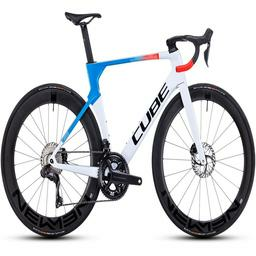

In [10]:
import PIL
# view x as image with PIL
PIL.Image.fromarray((x * 255).astype(np.uint8))

In [11]:
model2 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False)
model2.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                        

In [12]:
# count conv2d layers in model2
conv2d_indices = []
for i, layer in enumerate(model2.layers):
    if layer.name.endswith("conv"):
        conv2d_indices.append(i)

len(conv2d_indices)

53

In [13]:
 # each block has approximately 3 conv2d layers
model2.layers[conv2d_indices[-3*3 +1]].name

'conv5_block1_0_conv'

In [14]:
conv2d_indices[-3*3 +1]

163

In [12]:
def save_weights(model, weights_path):
  for layer in model.layers:
    layer.trainable=False
  ''' for layer in base_model.layers:
    layer.trainable=False '''
  
  model.save(weights_path)

In [6]:


def make_model(base_model, weights_path=None):
  
 
    
    

  base_model.trainable = False

  inputs = tf.keras.Input(shape=(256, 256, 3))
  x = base_model(inputs, training=True) # training=True only enabled for unfrozen layers (?)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(1, activation='relu')(x) # use relu because prices are always positive
  model = tf.keras.Model(inputs, outputs)

 
  if weights_path is not None:
    model.load_weights(weights_path)

  # freeze base model
  for layer in base_model.layers[163:]: # last, conv5 section
    layer.trainable = True 

  
  return model
  
# create keras resnet 50 v2 model



In [7]:
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
model = make_model(base_model)

In [84]:
# save_weights(model, '/content/drive/MyDrive/Data/BikePricePredict/test.h5')

In [8]:
# model = make_model(base_model, '/content/drive/MyDrive/Data/BikePricePredict/test.h5')

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, ), # beta1, beta2, weight_decay
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mse']
              )

In [10]:
import pandas as pd
def fit(model, batch_size , epochs, save_after_epochs, start_epoch_num, lr,  dir='/content/drive/MyDrive/Data/BikePricePredict/'):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, ), # beta1, beta2, weight_decay
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mse']
              )
  for ep in range(save_after_epochs, epochs+save_after_epochs, save_after_epochs):
    print(f'fit {ep+start_epoch_num}')
    with tf.device('/GPU:0'):

        history = model.fit(dataset.batch(batch_size), epochs=save_after_epochs)


    # Convert the history to a Pandas DataFrame
    history_df = pd.DataFrame(history.history)

    # Save the history to a CSV file
    history_df.to_csv(dir+f'history_{str(ep+start_epoch_num)}_lr{str(lr)}.csv', index=False)
    save_weights(model, dir+f'weights_{str(ep+start_epoch_num)}_lr{str(lr)}.h5')
    

In [ ]:
fit(model, batch_size=128, epochs=100000, save_after_epochs=100, start_epoch_num=100, lr=0.003)

fit 200
Epoch 1/100
45/45 [==============================] - 23s 392ms/step - loss: 5074923.0000 - mse: 5074923.0000
Epoch 2/100
45/45 [==============================] - 18s 390ms/step - loss: 5059767.0000 - mse: 5059767.0000
Epoch 3/100
45/45 [==============================] - 18s 384ms/step - loss: 5051419.0000 - mse: 5051419.0000
Epoch 4/100
45/45 [==============================] - 18s 385ms/step - loss: 5046271.5000 - mse: 5046271.5000
Epoch 5/100
45/45 [==============================] - 18s 387ms/step - loss: 5015804.5000 - mse: 5015804.5000
Epoch 6/100
45/45 [==============================] - 18s 387ms/step - loss: 5003096.0000 - mse: 5003096.0000
Epoch 7/100
45/45 [==============================] - 18s 385ms/step - loss: 5001004.5000 - mse: 5001004.5000
Epoch 8/100
45/45 [==============================] - 18s 385ms/step - loss: 4980143.0000 - mse: 4980143.0000
Epoch 9/100
45/45 [==============================] - 18s 386ms/step - loss: 4953109.5000 - mse: 4953109.5000
Epoch 10/10

In [ ]:



# train model, specify batch size
batch_size = 128
epochs = 50
if colab:
  with tf.device('/GPU:0'):
      history = model.fit(dataset.batch(batch_size), epochs=epochs)
else:
  history = model.fit(dataset.batch(batch_size), epochs=epochs)

# plot history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [ ]:
# visualize part of the image which contributed most to the prediction
def visualize_heatmap(model, image):
    # get prediction
    prediction = model.predict(image[np.newaxis, ...])[0]
    # get gradient
    with tf.GradientTape() as tape:
        # cast image to float32
        inputs = tf.cast(image[np.newaxis, ...], tf.float32)
        # watch the input pixels
        tape.watch(inputs)
        # get the predictions
        predictions = model(inputs)
      
    print(predictions.shape)
    # get the gradient of the loss with respect to the inputs
    gradients = tape.gradient(predictions, inputs)
    # get the mean gradient across the channels
    gradient = tf.reduce_mean(gradients, axis=(0, 3))
    # get the mean prediction across the channels
    prediction = predictions#tf.reduce_mean(predictions, axis=3)[0]
    # scale the prediction
    prediction /= tf.reduce_max(prediction)
    # scale the gradient
    gradient /= tf.reduce_max(gradient)
    # upsample the prediction and the gradient
    prediction = tf.image.resize(prediction, [256, 256])
    gradient = tf.image.resize(gradient, [256, 256])
    # convert to numpy
    prediction = prediction.numpy()
    gradient = gradient.numpy()
    # plot the prediction and the gradient
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.imshow(prediction, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(gradient, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

visualize_heatmap(model, x)